In [5]:
from loader import PR_Dataset
import pandas as pd 
from cfg import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
from loader import ImgPad
from monai import transforms 
from loader import data_pipe
import fast_glcm
from skimage import data
from skimage.feature import texture
import glob
from personal_cls import run

In [6]:

def glcm_features(f):
    img = cv2.imread(f, 0)
    g = texture.greycomatrix(img, [1, 2,3 ,4, 5], [0, np.pi/2], levels=256, normed=True, symmetric=True)
    features = []
    for p in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        f = texture.greycoprops(g, p)
        features.append(f)
    return np.array(features).flatten()


labels = [0, 1]
dtype = ['T1', 'T1c', 'T2', 'Flair', 'Mixed']
# dtype = ['T1c']

X, y = [], []
for label in labels:
    pr_class = 'PR' if label else 'non_PR'
    for f in glob.glob(f'{segmented_img_dir}/{pr_class}/T1c/*.jpg'):
        mri_features = []
        # for d in ['T1c']:
        for d in ['T1c', 'T1', 'T2', 'Flair']:
            textual_feature = glcm_features(f.replace('T1c', d))
            mri_features.append(textual_feature)
            
        X.append(np.array(mri_features).flatten())
        y.append(label)

rawX, y = np.array(X), np.array(y)

In [7]:
from comet_ml import Experiment
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.svm import SVC, NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


print(rawX.shape, y.shape)
X = pd.DataFrame(rawX)

thr = .8
X = VarianceThreshold(threshold=(thr * (1 - thr))).fit_transform(X)
print('After VT transform | dim', X.shape[1])
# X = SelectKBest(chi2, k=50).fit_transform(X, y)
X = SelectPercentile(chi2, percentile=20).fit_transform(X, y)
print('After univariate selection | dim', X.shape[1])

# X = ( X-X.mean() )/  X.std()
X.shape

(56, 240) (56,)
After VT transform | dim 80
After univariate selection | dim 16


(56, 16)

In [8]:
experiment = Experiment(
    api_key=COMET_APT_KEY,
    project_name=COMET_PROJECT_NAME,
    workspace=COMET_WORK_SPACE,
    # disabled=True,
)

class CLF(NuSVC):
    def predict(self, X, **kwargs):
        super(NuSVC).__init__(**kwargs)
        threshold = .5
        result = self.predict_proba(X, **kwargs)
        return [1 if p>threshold else 0 for p in result[:,1]]

# clf = NuSVC(class_weight='balanced', max_iter=-1, nu=.05, kernel='rbf')
# clf = CLF(class_weight='balanced', max_iter=-1, nu=, probability=True)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1, max_depth=3, )
# clf = KNeighborsClassifier(n_neighbors=5, leaf_size=30)
# clf = RandomForestClassifier(max_depth=4, random_state=0, n_estimators=20)

result = run(X, y, clf)
met =  ['accuracy', 'precision', 'recall', 'roc_auc']
metric = ['train_' + val for val in met] + ['test_' + val for val in met]

total_result = {}
for m in metric: total_result[m] = []

for i in range(5):
    result = run(X, y, clf)
    for m in metric: total_result[m].append(result[m])

print(clf.__class__.__name__)
for m in met: 
    print(m ,'|\t', np.mean(result[f'train_{m}']), np.mean(result[f'test_{m}']))
# for m in result : print(m, '|',np.mean(result[m]))




COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wtyo1768/pr-classifier/ece44ab7d3b345e484b320e0f6b5f5db



GradientBoostingClassifier
accuracy |	 1.0 0.7666666666666667
precision |	 1.0 0.65
recall |	 1.0 0.29999999999999993
roc_auc |	 1.0 0.8203703703703702


In [9]:

f = '/home/rockyo/Chemei-PR/data/segmented_img/non_PR/T2/19425238.jpg'
# data, meta = LoadImage()(f)
data_pipe = {   
    # 'train': lambda stat:T.Compose(train_aug(stat)),
    # 'eval' : lambda stat:T.Compose(test_aug(stat)),
    'train' : transforms.Compose([
        transforms.LoadImage(image_only=True, reader='pilreader'),
        transforms.AddChannel(),
        transforms.RepeatChannel(3),
        # transforms.HistogramNormalize(),
        transforms.ScaleIntensity(),
        transforms.RandGaussianNoise(prob=0.4),
        transforms.Affine(
            rotate_params=np.pi/4, scale_params=(1.2, 1.2),
            translate_params=(5, 5), padding_mode='zeros', image_only=True
        ),
        transforms.RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        transforms.RandFlip(spatial_axis=0, prob=0.5),
        transforms.RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        
        transforms.SpatialPad(spatial_size=[IMAGE_SIZE, IMAGE_SIZE, ]),
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE, ]),
        transforms.EnsureType(),
    ]),
    'eval' : transforms.Compose([
        transforms.LoadImage(image_only=True, reader='pilreader'),
        transforms.AddChannel(),
        transforms.RepeatChannel(3),
        transforms.ScaleIntensity(),
        
        transforms.SpatialPad(spatial_size=[IMAGE_SIZE, IMAGE_SIZE, ]),
        transforms.Resize([IMAGE_SIZE, IMAGE_SIZE,]),
        transforms.EnsureType(),
    ]),
    'vis': transforms.Compose([
        transforms.LoadImage(image_only=True, reader='pilreader'),
        transforms.AddChannel(),
        transforms.RepeatChannel(3),
        transforms.EnsureType(),
    ]),
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(96, 96, 3)


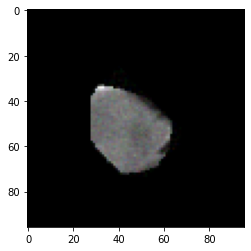

In [10]:
data = data_pipe['train'](f)
data = data.numpy()
data = np.moveaxis(data, 0, -1)
print(data.shape)
plt.imshow(data)
plt.show()
# data.max(), data.min()

# Img Statistic

In [11]:
test_aug = T.Compose([
    ImgPad(IMAGE_SIZE), 
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
    T.ToTensor(), 
])

def show_statistic(dtype):
    df = pd.read_excel(xls_file, sheet_name='Sheet2')
    ds = PR_Dataset(df, dtype, eval_mode=True)
    mean, std, sz = 0, 0, ds.__len__()
    s = torch.tensor([0, 0, 0])
    for i in range(sz):
        img = ds.features[i]['img']
        img = data_pipe['eval'](img)
        # img = data_pipe['vis'](img)

        mean += torch.mean(img.view(3, -1), 1)
        std += torch.std(img.view(3, -1), 1)
        s += torch.tensor(img.shape)
    print('Shape :', s / sz)
    print(f'mean : ', mean/(sz))
    print('std : ', std/(sz))
    
for d in ['T1', 'T1c', 'T2', 'Flair']: 
    show_statistic(d)


NameError: name 'T' is not defined

# Image Vis

In [ ]:
pad_and_resize = T.Compose([
    ImgPad(IMAGE_SIZE), 
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
])

def show_mri(dtype, T=None):
    df = pd.read_excel(xls_file, sheet_name='Sheet2')
    ds = PR_Dataset(df, dtype, eval_mode=False)
    columns, rows = 4, 5
    fig = plt.figure(figsize=(8, 8))

    for i in range(1, columns*rows +1):

        img = ds.features[i]['img']
        if T: img = T(img)
        else : img = pad_and_resize(img)

        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()  

for d in ['T1', 'T1c', 'T2', 'Flair']:  show_mri(d)

[0.64772727 2.19230769]
T1 | 56 images found


AttributeError: 'str' object has no attribute 'size'

<Figure size 576x576 with 0 Axes>